In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler

# EDA

In [41]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [43]:
print(df.shape)
print(df.isnull().sum())
print(df.isnull().sum().sum()/len(df)*100)

(768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
0.0


In [44]:
# 1. Removing null rows
print(df.shape) #(2126, 14)

# Since we have more number of rows, which may not affect the analysis, we can comfortably drop 21 rows from 2126 rows
df.dropna(inplace=True)
print(df.shape) #(2105, 14)

(768, 9)
(768, 9)


In [45]:
# 2. Removing duplicate values
print(df.duplicated().sum()) #2

# Since we only have 2 dulicate rows in 2105 rows, we can just delete them
df.drop_duplicates(inplace=True, ignore_index=True)
print(df.duplicated().sum()) #0
print(df.shape) #(2103, 14)

0
0
(768, 9)


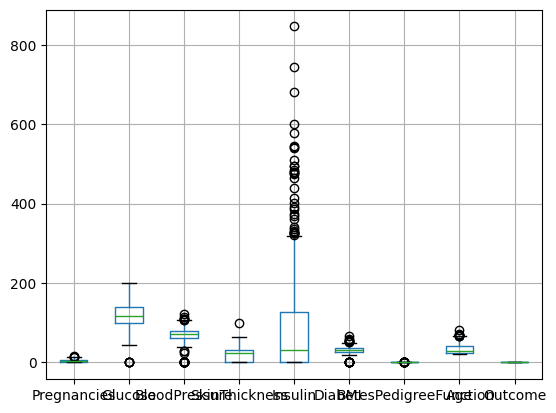

In [46]:
# 3. Detecting and Replacing the Outliers
df.boxplot()
plt.show()

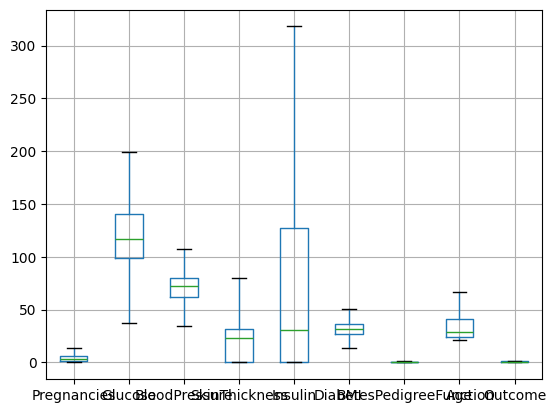

In [47]:
def replace_outliers(df):
    def replace(col):
        Q1 = df[col].quantile(0.25)        
        Q3 = df[col].quantile(0.75)     
        IQR = Q3 - Q1
        lower_extreme = Q1 - 1.5*IQR   
        upper_extreme = Q3 + 1.5*IQR   
        df[col] = df[col].apply(lambda x: lower_extreme if x < lower_extreme else upper_extreme if x > upper_extreme else x)

    for c in df.select_dtypes(include=["int", "float"]).columns:
        replace(c)

replace_outliers(df)
df.boxplot()
plt.show()

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128987       0.184307      -0.084349   
Glucose                      0.128987  1.000000       0.197865       0.059806   
BloodPressure                0.184307  0.197865       1.000000       0.152644   
SkinThickness               -0.084349  0.059806       0.152644       1.000000   
Insulin                     -0.077793  0.315856       0.050080       0.488101   
BMI                          0.024681  0.235542       0.282544       0.401494   
DiabetesPedigreeFunction    -0.017398  0.120213       0.038793       0.177920   
Age                          0.549695  0.269056       0.304208      -0.119170   
Outcome                      0.220392  0.479158       0.113301       0.073125   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.077793  0.024681                 -0.017398   
Glucose                   0.315856  0.235

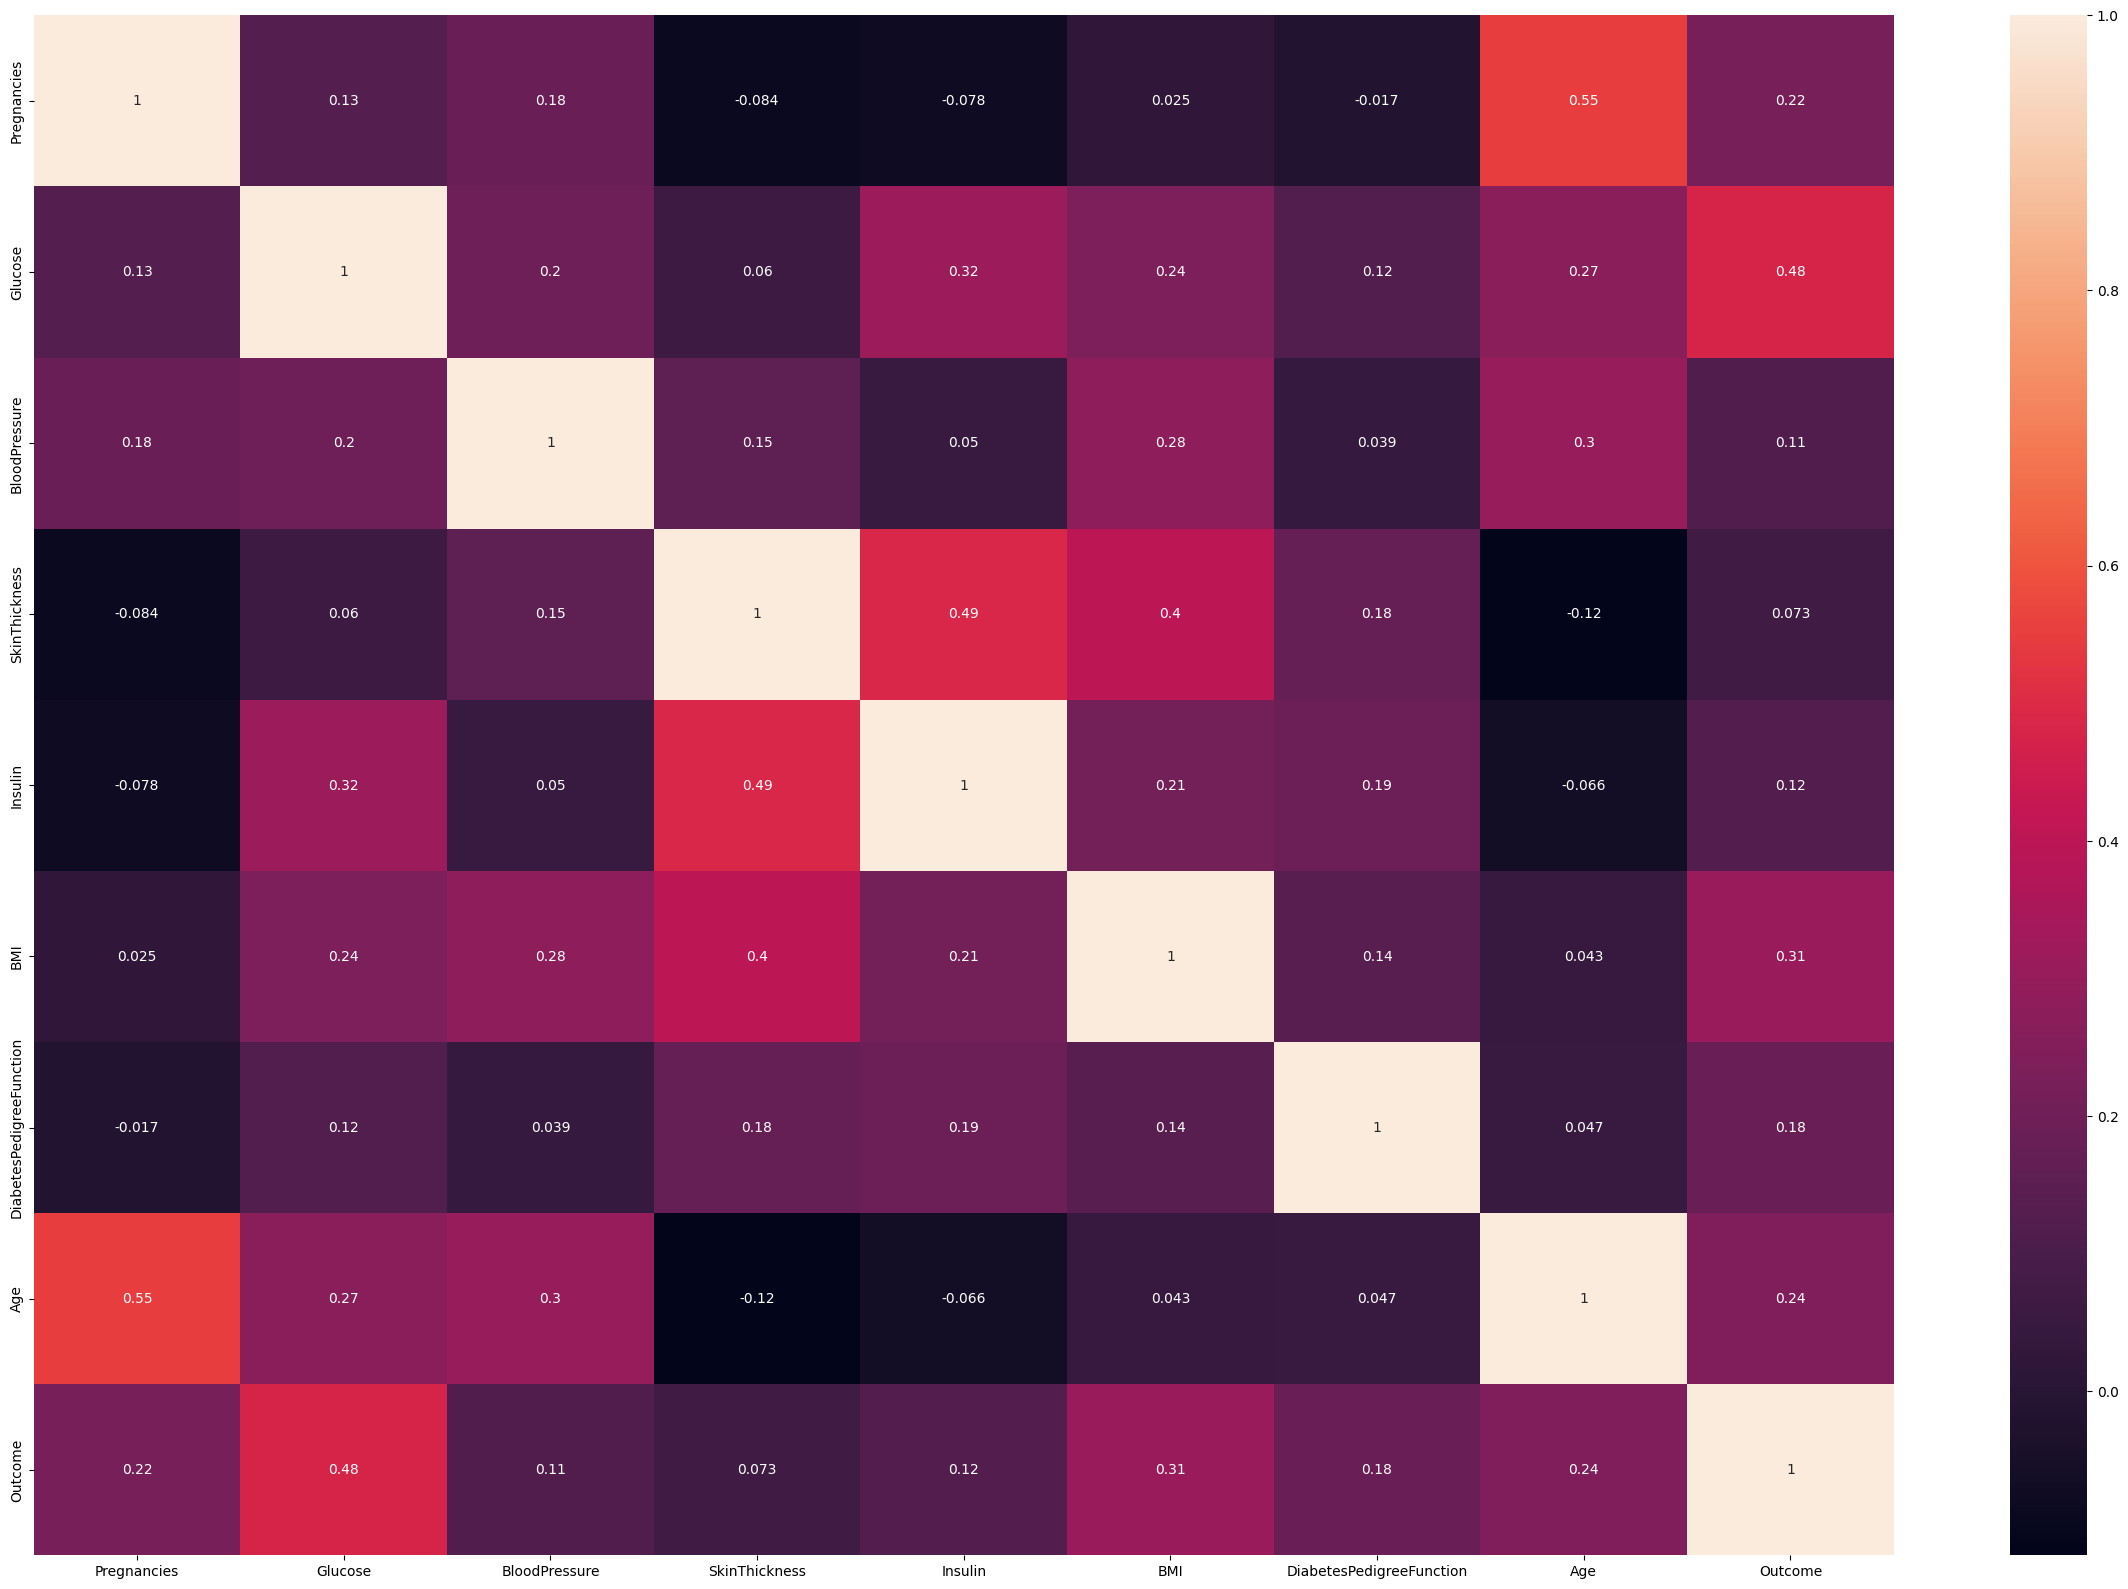

In [48]:
# 4. Multi-collinearity detection
corr = df.corr()
print(corr)
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True)
plt.show()

In [49]:
'''
Columns having multi-collinearity of more than 0.5
["Age", "Pregnancies"]


Columns having multi-collinearity of almost 0.5
["Insulin", "SkinThickness"]
["Glucose", "Outcome"]
'''

'\nColumns having multi-collinearity of more than 0.5\n["Age", "Pregnancies"]\n\n\nColumns having multi-collinearity of almost 0.5\n["Insulin", "SkinThickness"]\n["Glucose", "Outcome"]\n'

In [50]:
target = df["Outcome"]
features = df.drop(columns=["Outcome"])

In [51]:
# 5. Finding multi-collinearity with VIF
vif = pd.DataFrame()
vif["Features"] = features.columns
vif["VIF_SCORES"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif.sort_values(ascending=False, by="VIF_SCORES")

,Features,VIF_SCORES
2,BloodPressure,24.832962
5,BMI,24.035878
1,Glucose,19.086746
7,Age,14.725912
3,SkinThickness,4.264668
6,DiabetesPedigreeFunction,3.750631
0,Pregnancies,3.319215
4,Insulin,2.435731


In [52]:
'''
VIF scores of more than 10;
BloodPressure
BMI
Glucose
Age

Since Glucose is a very important parameter on calculating the Diabetes, we will first check by dropping the columns "BloodPressure" and "BMI" and then calculating the VIF, if the VIF scores for "Glucose" and "Age" are still high, we can drop "Age" and proceed further.

'''

# dropping "BloodPressure" and "BMI"
features.drop(columns=["BloodPressure", "BMI"], inplace=True)


In [53]:
vif = pd.DataFrame()
vif["Features"] = features.columns
vif["VIF_SCORES"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif.sort_values(ascending=False, by="VIF_SCORES")


'''
After dropping "BloodPressure" and "BMI", the VIF for "Glucose" and "Age" seems to be not that more than 10. So we can risk keeping it and checking for the model quality.
'''

'\nAfter dropping "BloodPressure" and "BMI", the VIF for "Glucose" and "Age" seems to be not that more than 10. So we can risk keeping it and checking for the model quality.\n'

[ 39.1060998  228.27899638   4.11804863  12.10361486  27.13587638
  47.94475658]


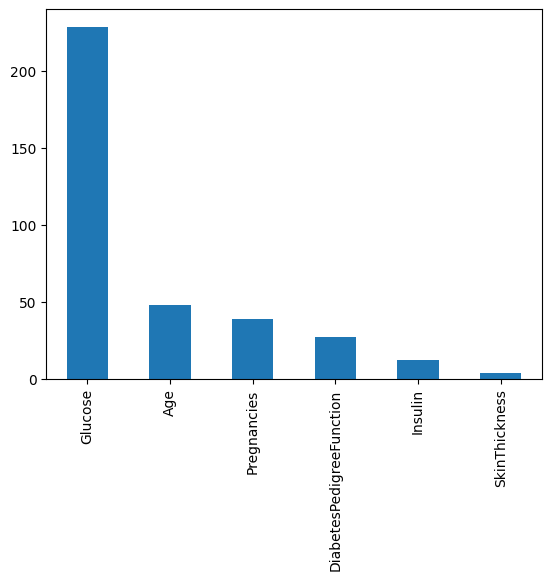

'\nf_reg[0]: [ 39.1060998  228.27899638   4.11804863  12.10361486  27.13587638\n  47.94475658]\n'

In [54]:
'''
6. Finding correlation of features with the target
'''

f_reg= f_classif(features,target)
print(f_reg[0])
pd.Series(f_reg[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()
'''
f_reg[0]: [ 39.1060998  228.27899638   4.11804863  12.10361486  27.13587638
  47.94475658]
'''

In [55]:
corrdf = pd.DataFrame()
corrdf["Features"] = features.columns
corrdf["Correlation"] = f_classif(features,target)[0]
print(corrdf.sort_values(ascending=False, by="Correlation"))

                   Features  Correlation
1                   Glucose   228.278996
5                       Age    47.944757
0               Pregnancies    39.106100
4  DiabetesPedigreeFunction    27.135876
3                   Insulin    12.103615
2             SkinThickness     4.118049


In [56]:
features.head()

,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
0,6.0,148.0,35.0,0.0,0.627,50.0
1,1.0,85.0,29.0,0.0,0.351,31.0
2,8.0,183.0,0.0,0.0,0.672,32.0
3,1.0,89.0,23.0,94.0,0.167,21.0
4,0.0,137.0,35.0,168.0,1.200,33.0


# Visualization

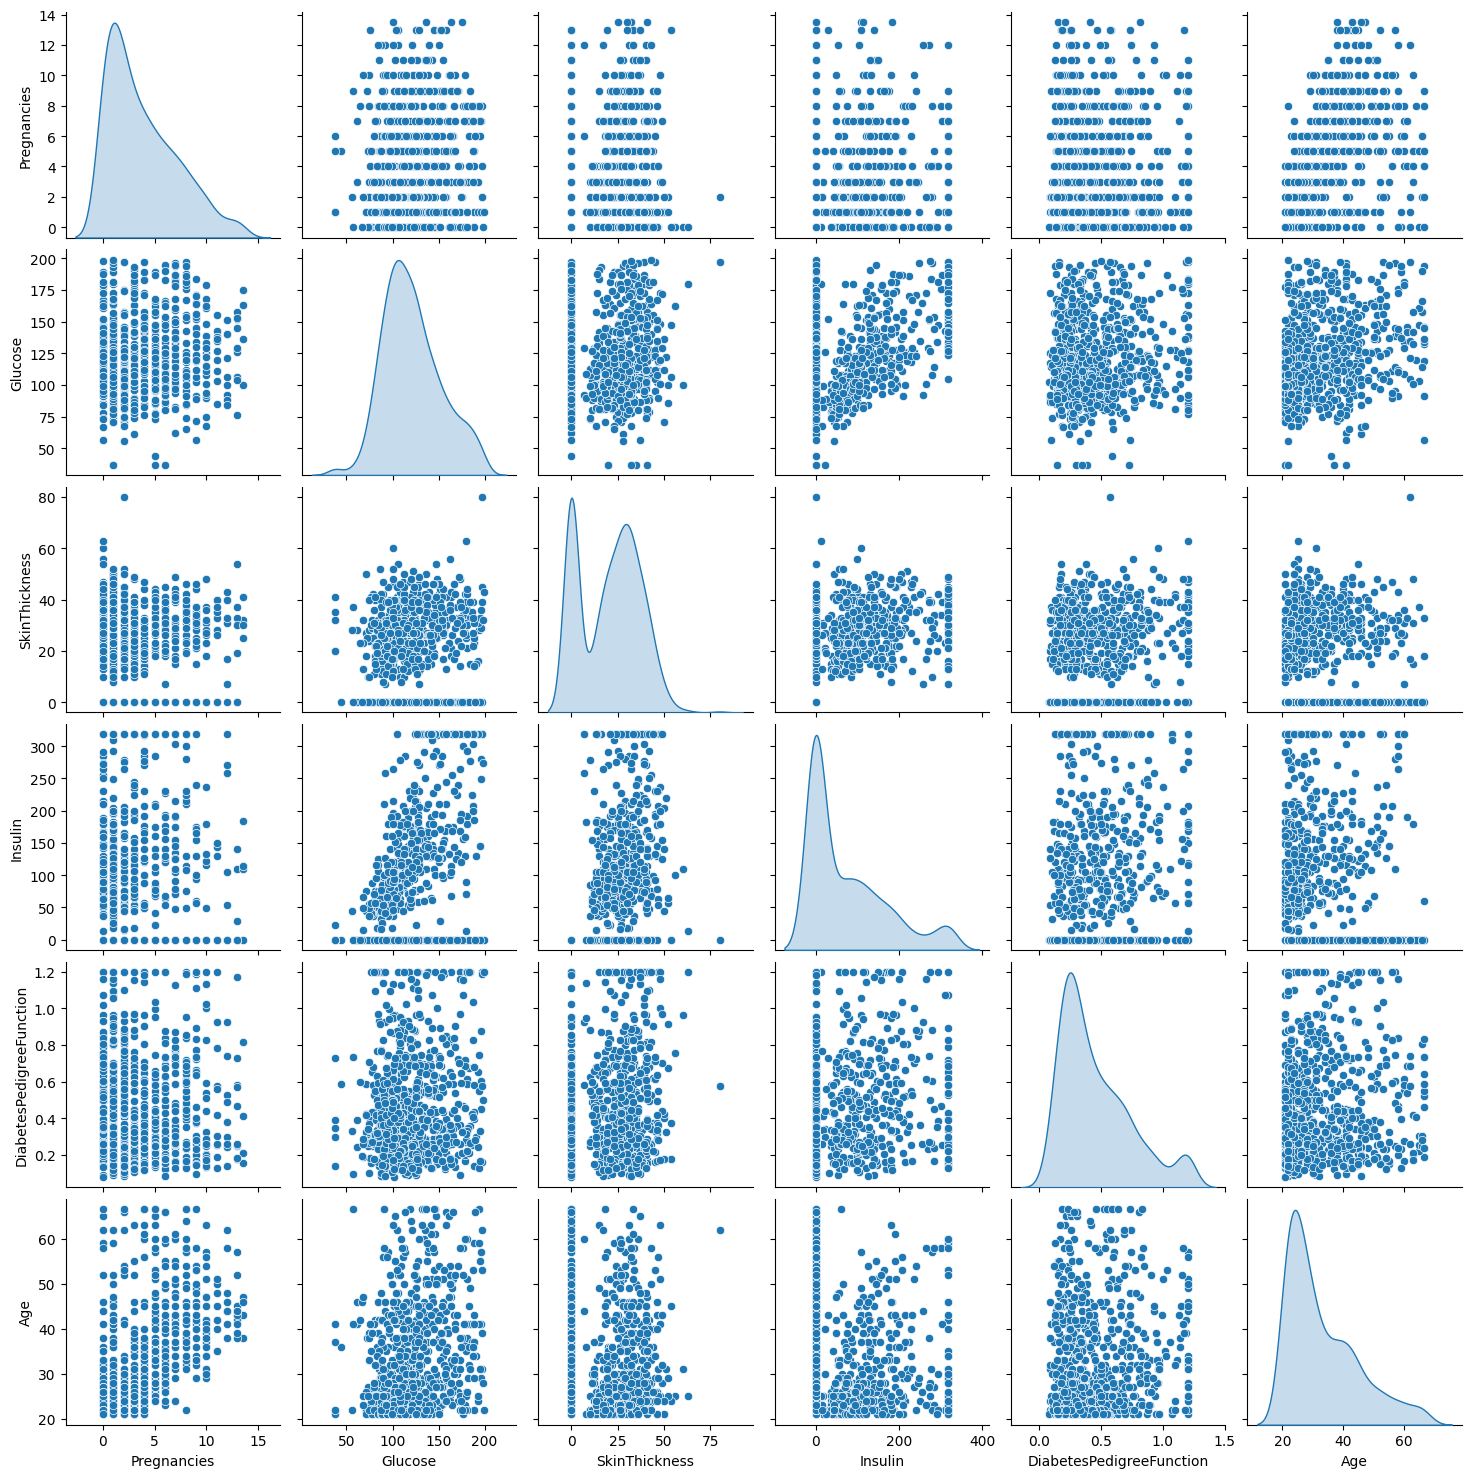

In [57]:
# 1. Pairplot
sns.pairplot(features, diag_kind="kde")
plt.show()


# None of any two columns seem to have an explicity visible positive/ negative correlation.

# Logistic Regression

In [58]:
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 150)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 6)
(154, 6)
(614,)
(154,)


In [59]:
features.head()

,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
0,6.0,148.0,35.0,0.0,0.627,50.0
1,1.0,85.0,29.0,0.0,0.351,31.0
2,8.0,183.0,0.0,0.0,0.672,32.0
3,1.0,89.0,23.0,94.0,0.167,21.0
4,0.0,137.0,35.0,168.0,1.200,33.0


In [60]:
# Scaling the data
std_scaler = StandardScaler()
x_train[["Glucose", "SkinThickness", "Insulin"]] = std_scaler.fit_transform(x_train[["Glucose", "SkinThickness", "Insulin"]])
x_test[["Glucose", "SkinThickness", "Insulin"]] = std_scaler.transform(x_test[["Glucose", "SkinThickness", "Insulin"]])

In [61]:
x_train.head()

,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
41,7.0,0.389148,-1.265756,-0.788493,0.696,37.0
624,2.0,-0.420533,-1.265756,-0.788493,0.158,21.0
116,5.0,0.097663,-1.265756,-0.788493,0.220,38.0
571,2.0,0.291986,-1.265756,-0.788493,0.268,21.0
677,0.0,-0.906341,-1.265756,-0.788493,0.263,25.0


In [62]:
# Finding the Co-efficients and the Intercepts
log_model = LogisticRegression()
log_model.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [63]:
print("Co-eficients = ", log_model.coef_)
print("Intercept = ", log_model.intercept_)

Co-eficients =  [[ 0.1058328   1.19285141  0.21437141 -0.13678772  0.84535454  0.01555677]]
Intercept =  [-2.08974328]


In [64]:
# Finding the sigmoid values

log_model.predict_proba(x_test)[:5] # Returns [probablity_value_of_0, probablity_value_of_1][]

array([[0.52476039, 0.47523961],
       [0.76876083, 0.23123917],
       [0.36380905, 0.63619095],
       [0.46357744, 0.53642256],
       [0.97446778, 0.02553222]])

In [65]:
# Finding the prediction 
y_pred_test = log_model.predict(x_test)
y_pred_test

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [66]:
# Finding the accuracy score
accuracy_score(y_test, y_pred_test)

0.7597402597402597

In [67]:
# Finding log loss with sigmoid values
sigmoid_test = log_model.predict_proba(x_test)[:,1]
sigmoid_test

array([0.47523961, 0.23123917, 0.63619095, 0.53642256, 0.02553222,
       0.26464564, 0.14161118, 0.29247246, 0.47199099, 0.77043486,
       0.20058483, 0.07085058, 0.17843321, 0.2983972 , 0.75391579,
       0.0971579 , 0.07943715, 0.28305394, 0.37809189, 0.79755954,
       0.24501144, 0.53563631, 0.2970254 , 0.11915294, 0.6480863 ,
       0.2819529 , 0.7809786 , 0.19670082, 0.32308147, 0.6015962 ,
       0.40677401, 0.34423562, 0.4839597 , 0.0304954 , 0.63250912,
       0.51376181, 0.09467352, 0.9139959 , 0.07812451, 0.10154987,
       0.53862562, 0.58544871, 0.26222941, 0.08627738, 0.57414623,
       0.8808761 , 0.48294349, 0.7689074 , 0.56800149, 0.83312329,
       0.80291139, 0.11878003, 0.25691256, 0.18180503, 0.89826901,
       0.3165745 , 0.10383847, 0.24594095, 0.51536867, 0.11794662,
       0.22555579, 0.39693966, 0.09066652, 0.16425528, 0.08581231,
       0.34447288, 0.88610673, 0.48335266, 0.50576435, 0.2508521 ,
       0.14232425, 0.19354847, 0.15065682, 0.48255112, 0.90169

In [68]:
print(y_test[:10])
print(sigmoid_test[:10])
log_loss(y_test, sigmoid_test)

261    1
255    1
285    0
312    1
62     0
393    0
747    0
731    1
94     0
375    1
Name: Outcome, dtype: int64
[0.47523961 0.23123917 0.63619095 0.53642256 0.02553222 0.26464564
 0.14161118 0.29247246 0.47199099 0.77043486]


0.5101962961694916

In [69]:
# Adjusting the threshold
y_pred_x_test_adj = [1 if x[1] >= 0.5 else 0 for x in log_model.predict_proba(x_test)]
print(y_pred_test[:10])
y_pred_x_test_adj[:10]

[0 0 1 1 0 0 0 0 0 1]


[0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

In [70]:
# Finding the accuracy score after adjusting the threshold
accuracy_score(y_test, y_pred_x_test_adj)


'''
Adjusting the threshold doesn't seem to largely impact the accuracy score
'''

"\nAdjusting the threshold doesn't seem to largely impact the accuracy score\n"

# Performance Metrics

In [71]:
# Confusion Matrix
conf = confusion_matrix(y_test, y_pred_test)
conf

array([[87, 15],
       [22, 30]])

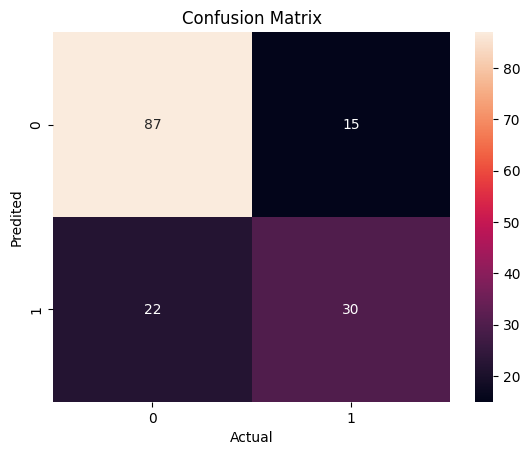

In [72]:
sns.heatmap(conf, annot=True)
plt.xlabel("Actual")
plt.ylabel("Predited")
plt.title("Confusion Matrix")
plt.show()

In [73]:
print(classification_report(y_test,y_pred_test))



'''
Macro Avg - [(0.75+0.50)/2, ..., (0.84+0.22)/2]
Weighted Avg - [(0.73*0.75)+(0.26*0.50), ..., (0.73*0.84)+(0.26*0.22)]
'''

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       102
           1       0.67      0.58      0.62        52

    accuracy                           0.76       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.76      0.76       154



'\nMacro Avg - [(0.75+0.50)/2, ..., (0.84+0.22)/2]\nWeighted Avg - [(0.73*0.75)+(0.26*0.50), ..., (0.73*0.84)+(0.26*0.22)]\n'

In [74]:
# ROC Curve
auc_score = roc_auc_score(y_test, sigmoid_test)
print(auc_score)


roc_data = roc_curve(y_test, sigmoid_test)
print(roc_data)


0.7999622926093514
(array([0.        , 0.        , 0.        , 0.00980392, 0.00980392,
       0.01960784, 0.01960784, 0.02941176, 0.02941176, 0.03921569,
       0.03921569, 0.05882353, 0.05882353, 0.06862745, 0.06862745,
       0.09803922, 0.09803922, 0.10784314, 0.10784314, 0.11764706,
       0.11764706, 0.12745098, 0.12745098, 0.15686275, 0.15686275,
       0.19607843, 0.19607843, 0.21568627, 0.21568627, 0.23529412,
       0.23529412, 0.26470588, 0.26470588, 0.2745098 , 0.2745098 ,
       0.28431373, 0.28431373, 0.30392157, 0.30392157, 0.37254902,
       0.37254902, 0.44117647, 0.44117647, 0.47058824, 0.47058824,
       0.58823529, 0.58823529, 0.64705882, 0.64705882, 0.69607843,
       0.69607843, 0.70588235, 0.70588235, 0.76470588, 0.76470588,
       1.        ]), array([0.        , 0.01923077, 0.05769231, 0.05769231, 0.07692308,
       0.07692308, 0.19230769, 0.19230769, 0.23076923, 0.23076923,
       0.32692308, 0.32692308, 0.38461538, 0.38461538, 0.42307692,
       0.42307692, 0.

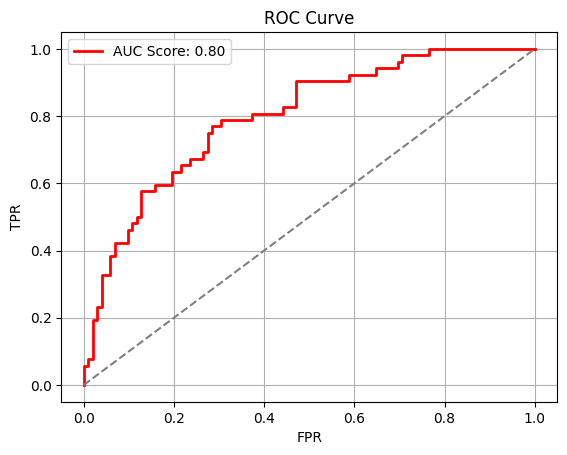

In [75]:
fpr, tpr, threshold = roc_data
plt.plot(fpr, tpr, lw=2, color="red", label=f"AUC Score: {auc_score:.2f}")
plt.plot([0,1], linestyle="--", color="grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [77]:
import pickle as pk

# Converting the model in to a Pickle file
file = "log_reg_assignment.pkl"
pk.dump(log_model, open(file, "wb"))

# Converting the standard scaler variable in to a Pickle file
file = "std_scaler_log_reg_assingment.pkl"
pk.dump(std_scaler, open(file, "wb"))

In [78]:
x_train.head()

,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
41,7.0,0.389148,-1.265756,-0.788493,0.696,37.0
624,2.0,-0.420533,-1.265756,-0.788493,0.158,21.0
116,5.0,0.097663,-1.265756,-0.788493,0.220,38.0
571,2.0,0.291986,-1.265756,-0.788493,0.268,21.0
677,0.0,-0.906341,-1.265756,-0.788493,0.263,25.0


In [ ]:
'''
1) Difference between Precision and Recall

a) Precision: Out of all predicted positives, how many are actually positive.

Precision = TP/ (TP + FP)
Precision: false positives


b) Recall: Out of all actual positives, how many were correctly predicted.

Recall = TP/ (TP + FN)​
Recall: false negatives

In Short;
Precision = correctness of positive predictions
Recall = coverage of actual positives




2) Cross-validation is a technique where data is split into multiple folds (e.g., 5 or 10). The model is trained on some folds and validated on the remaining fold, repeating this so every sample is tested once.

Why important in binary classification:
 - Gives a more reliable estimate of model performance
 - Reduces overfitting to a single train/test split
 - Helps detect class imbalance issues across folds
 - Ensures metrics like precision/recall are stable

In short;
Cross-validation checks how well a binary classifier generalizes to unseen data.
'''